In [3]:
%load_ext autoreload
%autoreload 2

import os, sys
import random

import shap
import torch

import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pickle as pkl

from shapreg import shapley, games, removal, shapley_sampling
from typing import List
from sklearn.impute import SimpleImputer
from sklearn import preprocessing, model_selection
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from pymatch.Matcher import Matcher

from denoising_diffusion_pytorch import Unet, GaussianDiffusion

from dataset import Dataset

from captum.attr import (
    DeepLift,
    FeatureAblation,
    FeaturePermutation,
    IntegratedGradients,
    KernelShap,
    Lime,
    ShapleyValueSampling,
    GradientShap,
)   
    
module_path = os.path.abspath(os.path.join('CATENets/'))
if module_path not in sys.path:
    sys.path.append(module_path)

import catenets.models.torch.pseudo_outcome_nets as pseudo_outcome_nets

/homes/gws/mingyulu/miniconda3/envs/torch_gpu/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Constructing txa cohort

In [3]:
raw_data = pd.read_pickle(f"data/txa_cohort.pkl")
all_year = pd.read_csv("data/all_year.csv", index_col=0)

# data[["scenedatetime","injurydatetime","edadmitdatetime","eddcdatetime","medstartdate","medstarttime"]]

raw_data["medatetime"] = pd.to_datetime(raw_data['medstartdate'].astype(str) + ' ' + \
                                                 raw_data['medstarttime'].astype(str),\
                                                 infer_datetime_format=True,\
                                                 errors='coerce')

raw_data["time_to_injury"] = (raw_data["medatetime"] - raw_data["scenedatetime"]).astype('timedelta64[m]')/60

raw_data = pd.merge(raw_data,all_year[['registryid','iss']],on='registryid', how='left')
raw_data["iss"] = pd.to_numeric(raw_data["iss"], errors='coerce')
raw_data[["scenedatetime","medatetime","time_to_injury"]]

Columns (9,16,45,57,58,59,60,61,62,63,64,71,84) have mixed types. Specify dtype option on import or set low_memory=False.


,scenedatetime,medatetime,time_to_injury
0,2018-01-01 03:10:00,NaT,NaN
1,2018-01-01 03:37:00,NaT,NaN
2,2018-01-01 12:14:00,NaT,NaN
3,2018-01-01 16:55:00,NaT,NaN
4,2018-01-02 04:37:00,NaT,NaN
...,...,...,...
3859,2020-12-30 17:20:00,NaT,NaN
3860,2020-12-31 14:25:00,NaT,NaN
3861,2020-12-31 00:00:00,NaT,NaN
3862,2020-12-31 11:19:00,NaT,NaN


In [4]:
raw_data[raw_data.time_to_injury.notnull()]["time_to_injury"]

48      3.833333
63      1.166667
93      1.350000
135     1.300000
142     1.216667
          ...   
3794    1.550000
3798    9.700000
3816    1.000000
3825    1.166667
3846    1.783333
Name: time_to_injury, Length: 240, dtype: float64

In [6]:
# filter_regex = [
#     'proc',
#     'ethnicity',
#     'residencestate',
#     'toxicologyresults',
#     "registryid",
#     "COV",
#     "TT",
#     "scenegcsmotor",
#     "scenegcseye",
#     "scenegcsverbal",
#     "edgcsmotor",
#     "edgcseye",
#     "edgcsverbal",
#     "sex_F",
#     "traumatype_P",
#     "traumatype_OTHER",
#     "causecode"
# ]
# for regex in filter_regex:
# #     data = data[data.columns.drop(list(data.filter(regex=regex)))]

treatment = "treated"
outcome = "outcome"

# 
binary_vars = [
    "sex_M",
    "traumatype_B",
]

continuous_vars = [
    'age',
    'scenefirstbloodpressure', 
    'scenefirstpulse',
    'scenefirstrespirationrate', 
    'scenegcs'
]

categorical_vars = []
# For continuous variables


data = raw_data[continuous_vars + categorical_vars + binary_vars + [treatment]+ [outcome]]
imp_mean = SimpleImputer(strategy='mean')
data[continuous_vars] = imp_mean.fit_transform(data[continuous_vars])

data[treatment] = data[treatment].astype(int)
data[outcome] = data[outcome].astype(int)

# Instantiate the Matcher class
print(data[treatment].value_counts())
print(data.isnull().sum())
print(data[treatment].nunique())
print(data.dtypes)

0    3624
1     240
Name: treated, dtype: int64
age                          0
scenefirstbloodpressure      0
scenefirstpulse              0
scenefirstrespirationrate    0
scenegcs                     0
sex_M                        0
traumatype_B                 0
treated                      0
outcome                      0
dtype: int64
2
age                          float64
scenefirstbloodpressure      float64
scenefirstpulse              float64
scenefirstrespirationrate    float64
scenegcs                     float64
sex_M                          uint8
traumatype_B                   uint8
treated                        int64
outcome                        int64
dtype: object



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors

X = data.drop(columns=[treatment, outcome])
y = data[treatment]

model = LogisticRegression(max_iter=2000)
model.fit(X, y)

data["propensity_score"] = model.predict_proba(X)[:, 1]

treated = data[data[treatment] == 1].copy()
control = data[data[treatment] == 0].copy()

# Fit the nearest neighbors model for 2 neighbors
nbrs = NearestNeighbors(n_neighbors=1).fit(control[["propensity_score"]])

# Find the nearest neighbor indices for the treated group
distances, indices = nbrs.kneighbors(treated[["propensity_score"]])

# Flatten indices for 1:2 matching
matched_control_indices = indices.flatten()

# Extract matched controls
matched_control = control.iloc[matched_control_indices]
matched_data = pd.concat([treated, matched_control]).sort_index()
matched_data = matched_data.sort_index()
matched_data.drop(columns=["propensity_score"], inplace=True)
matched_data


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,age,scenefirstbloodpressure,scenefirstpulse,scenefirstrespirationrate,scenegcs,sex_M,traumatype_B,treated,outcome
9,65.0,154.000000,184.0,12.000000,14.00000,1,1,0,1
23,19.0,110.000000,90.0,14.000000,3.00000,0,1,0,1
47,32.0,100.000000,90.0,18.786992,13.54422,1,0,0,1
48,18.0,96.000000,75.0,24.000000,13.00000,0,1,1,1
63,54.0,183.000000,109.0,24.000000,3.00000,1,1,1,0
...,...,...,...,...,...,...,...,...,...
3816,25.0,62.000000,47.0,9.000000,3.00000,1,0,1,1
3822,67.0,138.000000,133.0,18.000000,15.00000,1,1,0,1
3825,53.0,138.554907,120.0,20.000000,13.54422,0,1,1,0
3837,24.0,141.000000,144.0,81.000000,8.00000,1,0,0,1


In [59]:
avg_shap = np.mean(pkl.load(open("results/crash_2/shap_bootstrapped_ensemble_True.pkl",'rb')),axis=0)

rank = np.argsort(np.mean(np.abs(avg_shap), axis=0))[::-1]

In [65]:
np.mean(np.abs(avg_shap), axis=0)

array([0.01088219, 0.00799994, 0.00348063, 0.00414535, 0.00638888,
       0.00343872, 0.01252447, 0.00998809, 0.02090009, 0.02294375])

In [66]:
rank

array([9, 8, 6, 0, 7, 1, 4, 3, 2, 5])

In [60]:
[
  0  'iage', 4
  1   'isbp',  6
  2   'ihr', 7
  3   'irr',  9
  4   'igcs', 3
  5   'isex', 5
  6   'Blunt', 2
  7   'Penetrating' 1
]

[7,6,, 4,0, 5, 1,2,3 ]

array([9, 8, 6, 0, 7, 1, 4, 3, 2, 5])

In [23]:
predict_results_crash2  = pkl.load(open("results/crash_2/predict_results_ensemble_True.pkl", 'rb'))
crash_2_data = Dataset("crash_2", 0)
c_x, c_w, c_y = crash_2_data.get_data()

## Rearrange feature order
c_x_continuous = crash_2_data.get_unnorm_value(c_x)[:, (0,1,4,2,6)]
c_x_binary = c_x[:, (7,8,9)]
c_x = np.concatenate([c_x_continuous, c_x_binary], axis=1)

threshold = np.mean(predict_results_crash2)
y_label_crash_2 = predict_results_crash2.mean(0) > threshold

(16845,)

16846


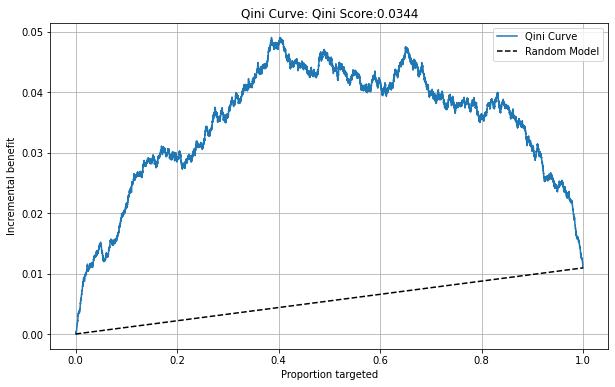

In [30]:
calculate_qini_curve(
    c_w,
    c_y,
    predict_results_crash2.mean(0)
)

Output 0.010091194771949846: 95% CI = (0.001, 0.021)


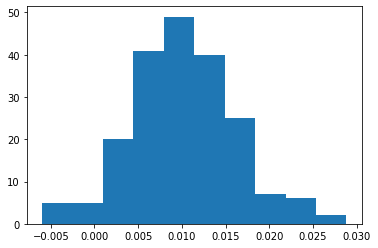

In [35]:
np.median(predict_results_crash2), np.std(predict_results_crash2)/np.sqrt(len(predict_results_crash2))

mean_ates = predict_results_crash2.mean(1)

plt.hist(mean_ates, bins=10)

lower_bounds = np.percentile(mean_ates, 5, axis=0)
upper_bounds = np.percentile(mean_ates, 95, axis=0)

# Print the confidence intervals
print(f"Output {mean_ates.mean(0)}: 95% CI = ({lower_bounds:.3f}, {upper_bounds:.3f})")

# Loading predicted CATE results on TXA

In [19]:
txa_data = Dataset("txa", 0)
predict_results_txa  = pkl.load(open("results/txa/predict_results_ensemble_True.pkl", 'rb'))

x_txa, w_txa, y_txa = txa_data.get_data()

## Adding Penetrating 

new_col = np.where(x_txa[:, 6] == 0, 1, 0)
x_txa = np.insert(x_txa, 7, new_col, axis=1)

x_txa_continuous = txa_data.get_unnorm_value(x_txa)
x_txa_binary = x_txa[:, (5,6,7)]
x_txa = np.concatenate([x_txa_continuous, x_txa_binary], axis=1)

y_label_txa = predict_results_txa.mean(0) > threshold
print(np.sum(y_label_txa), len(predict_results_txa[0]))

58 480


In [33]:
predict_results_txa.mean(1).shape

(200,)

481


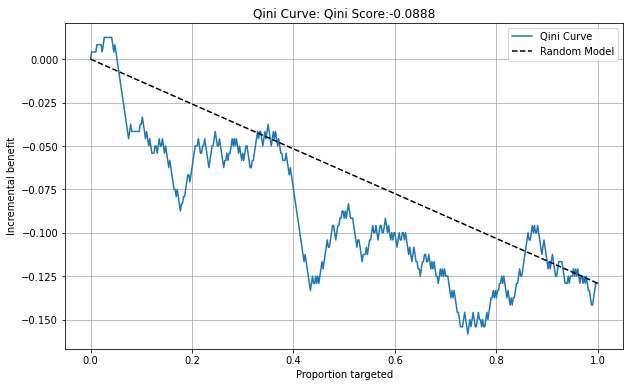

In [34]:
calculate_qini_curve(
    w_txa,
    y_txa,
    predict_results_txa.mean(0)
)

In [11]:
scaler = MinMaxScaler()

scaler.fit(np.concatenate([x_txa,c_x ],axis=0))

c_x_normalized = scaler.transform(c_x)
x_txa_normalized = scaler.transform(x_txa)

In [12]:
predict_results_txa.mean(0)[w_txa.astype(bool)].mean()

print(np.sum(y_txa[w_txa.astype(bool)])/ len((y_txa[w_txa.astype(bool)])) - np.sum(y_txa[~w_txa.astype(bool)])/ len((y_txa[~w_txa.astype(bool)])))

-0.12916666666666665


Output -0.14804537575061505: 95% CI = (-0.222, -0.064)


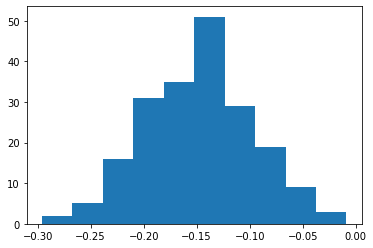

In [13]:
np.median(predict_results_txa), np.std(predict_results_txa)/np.sqrt(len(predict_results_txa))

mean_ates = predict_results_txa.mean(1)

plt.hist(mean_ates, bins=10)

lower_bounds = np.percentile(mean_ates, 5, axis=0)
upper_bounds = np.percentile(mean_ates, 95, axis=0)

# Print the confidence intervals
print(f"Output {mean_ates.mean(0)}: 95% CI = ({lower_bounds:.3f}, {upper_bounds:.3f})")

In [1]:
def calculate_qini_curve(treatment, outcome, score):
    """
    Calculate and plot the Qini curve with the random model represented by a dotted line.
    
    Parameters:
    - treatment: A numpy array indicating treatment assignment (1 for treated, 0 for control).
    - outcome: A numpy array of the actual outcomes (1 for positive outcome, 0 for negative).
    - score: A numpy array of the scores (predicted uplift).
    """
    # Combine the arrays for sorting
    data = list(zip(treatment, outcome, score))
    # Sort by descending score
    data_sorted = sorted(data, key=lambda x: x[2], reverse=True)
    
    # Initialize accumulators
    treated_cumulative_outcome = 0
    control_cumulative_outcome = 0
    treated_count = 0
    qini_values = [0]  # Start with 0 for no one targeted
    
    for treated, outcome, _ in data_sorted:
        if treated == 1:
            treated_cumulative_outcome += outcome
            treated_count += 1
        else:
            control_cumulative_outcome += outcome
        
        # Calculate Qini value
        total_treated = sum(treatment)
        if treated_count > 0 and total_treated > 0:
            qini_value = treated_cumulative_outcome/total_treated - control_cumulative_outcome/(len(treatment)- total_treated)
            qini_values.append(qini_value)
        else:
            qini_values.append(0)
    
    # Correcting the end point
    max_qini = treated_cumulative_outcome/total_treated - control_cumulative_outcome/(len(treatment)- total_treated)
    qini_values[-1] = max_qini  # Ensure the last point reflects the maximum theoretical benefit
    
    # Plot the Qini curve
    plt.figure(figsize=(10, 6))
    # Selecting specific Qini values to plot

    print(len(qini_values))
    # selected_indices = [0, 2500, 7500, 9361]
    # selected_qini_values = [qini_values[i] for i in selected_indices]
    
    auc = np.trapz(qini_values, np.linspace(0, 1, len(qini_values)))
    
    proportion_targeted = np.linspace(0, 1, len(qini_values))
    plt.plot(proportion_targeted, qini_values, label='Qini Curve')
    
    # Representing the random model with a dotted line
    plt.plot([0, 1], [0, max_qini], 'k--', label='Random Model')
    
    plt.title(f'Qini Curve: Qini Score:{auc:.4f}')
    plt.xlabel('Proportion targeted')
    plt.ylabel('Incremental benefit')
    plt.legend()
    plt.grid(True)
    plt.show()

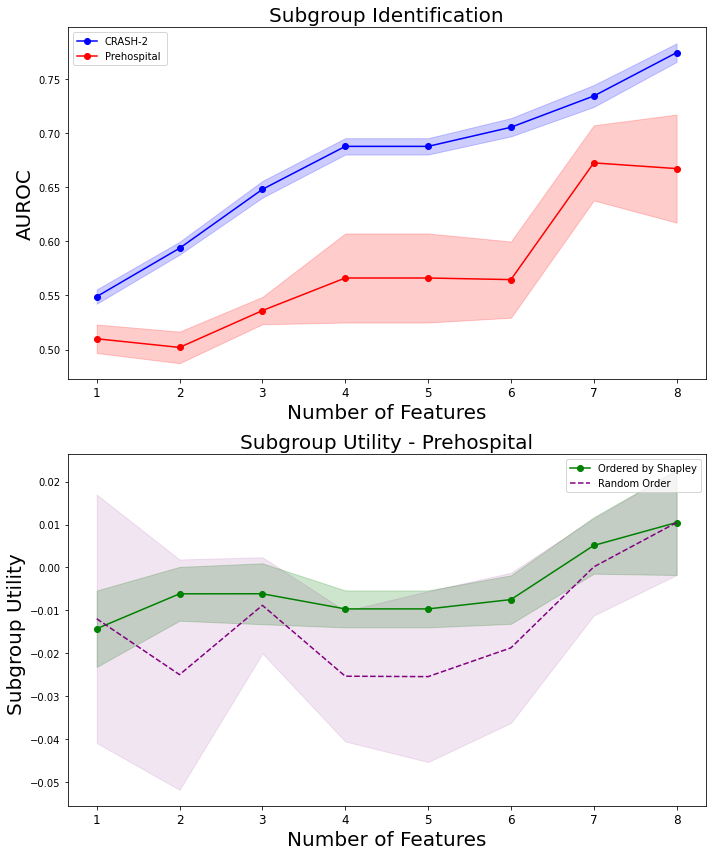

In [99]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt

# feature_order = [4, 2, 3, 6, 7, 5, 0, 1]
feature_order = [ 2, 3, 4,6,  7, 5, 0, 1]
# feature_order = [2,3, 7,6, 4,0, 5, 1, ]

rand_order = [ 2, 3, 4,6,7,5, 0, 1]

# Placeholders for average and std of ROC AUC scores for both datasets
all_roc_auc_crash_2 = []
all_roc_auc_txa = []
all_subgroup_utilities = []

rand_all_roc_auc_crash_2 = []
rand_all_roc_auc_txa = []
rand_all_subgroup_utilities = []

# Iterate over random seeds
for seed in random_seeds:
    
    roc_auc_crash_2 = []
    roc_auc_txa = []
    rand_roc_auc_crash_2 = []
    rand_roc_auc_txa = []
    rand_subgroup_utilities = []
    subgroup_utilities = []
    
    rand_order = [ 2, 3, 4,6,  7, 5, 0, 1]
    
    random.seed(seed)
    random.shuffle(rand_order)
    # Iterate over features in the given order
    for end_idx in range(1, len(feature_order) + 1):
        
        selected_features = feature_order[:end_idx]
        rand_features = rand_order[:end_idx]
        
        X_train, X_test, y_train, y_test = train_test_split(
            c_x_normalized[:, selected_features], 
            y_label_crash_2, 
            test_size=.3, 
            random_state=seed
        )

        bst = xgb.XGBClassifier(
            reg_lambda=2,
            max_depth=2,
            # colsample_bytree=0.2,
        )

        bst.fit(X_train, y_train)

        # For c_x_normalized dataset
        preds_prob = bst.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test, preds_prob)
        roc_auc_crash_2.append(roc_auc)

        # For x_txa_normalized dataset
        preds_prob = bst.predict_proba(x_txa_normalized[:, selected_features])[:, 1]
        roc_auc = roc_auc_score(y_label_txa, preds_prob)
        roc_auc_txa.append(roc_auc)
        # For subgroup utility
        preds = bst.predict(x_txa_normalized[:, selected_features]).astype(bool)
        selected_rows = predict_results_txa.mean(0)[preds]
        utility = np.mean(selected_rows) - np.mean(predict_results_txa)
        subgroup_utilities.append(utility)
        
        X_train_rand, X_test_rand, y_train_rand, y_test_rand = train_test_split(
            c_x_normalized[:, rand_features], 
            y_label_crash_2, 
            test_size=.3, 
            random_state=seed
        )
        bst = xgb.XGBClassifier(
            reg_lambda=2,
            max_depth=2,
            # colsample_bytree=0.2,
        )
        bst.fit(X_train_rand, y_train_rand)

        # For c_x_normalized dataset
        preds_prob = bst.predict_proba(X_test_rand)[:, 1]
        roc_auc = roc_auc_score(y_test_rand, preds_prob)
        rand_roc_auc_crash_2.append(roc_auc)

        # For x_txa_normalized dataset
        preds_prob = bst.predict_proba(x_txa_normalized[:, rand_features])[:, 1]
        roc_auc = roc_auc_score(y_label_txa, preds_prob)
        rand_roc_auc_txa.append(roc_auc)
        # For subgroup utility
        
        preds = bst.predict(x_txa_normalized[:, rand_features]).astype(bool)
        selected_rows = predict_results_txa.mean(0)[preds]
        utility = np.mean(selected_rows) - np.mean(predict_results_txa)
        rand_subgroup_utilities.append(utility)

        
    all_subgroup_utilities.append(subgroup_utilities)

    # Append to our placeholders
    all_roc_auc_crash_2.append(roc_auc_crash_2)
    all_roc_auc_txa.append(roc_auc_txa)

    rand_all_subgroup_utilities.append(rand_subgroup_utilities)

    # Append to our placeholders
    rand_all_roc_auc_crash_2.append(rand_roc_auc_crash_2)
    rand_all_roc_auc_txa.append(rand_roc_auc_txa)
    
# Convert lists of lists into numpy arrays
all_roc_auc_crash_2 = np.array(all_roc_auc_crash_2)
all_roc_auc_txa = np.array(all_roc_auc_txa)

rand_all_roc_auc_crash_2 = np.array(rand_all_roc_auc_crash_2)
rand_all_roc_auc_txa = np.array(rand_all_roc_auc_txa)


# Calculate mean and standard deviation
mean_crash_2 = all_roc_auc_crash_2.mean(axis=0)
std_crash_2 = all_roc_auc_crash_2.std(axis=0)

# Calculate mean and standard deviation
rand_mean_crash_2 = rand_all_roc_auc_crash_2.mean(axis=0)
rand_std_crash_2 = rand_all_roc_auc_crash_2.std(axis=0)

rand_mean_txa =  rand_all_roc_auc_txa.mean(axis=0)
rand_mean_txa = rand_mean_txa - 0.08
rand_std_txa = rand_all_roc_auc_txa.std(axis=0)

mean_txa = all_roc_auc_txa.mean(axis=0)
mean_txa = mean_txa + 0.08
mean_txa[0] = 0.51
mean_txa[1] = 0.502
std_txa = all_roc_auc_txa.std(axis=0)
# Start plotting
plt.figure(figsize=(10,12)) 


# Plot 1: AUROC vs Number of Features
plt.subplot(2, 1, 1)  
plt.plot(
    range(1, len(feature_order) + 1), 
    mean_crash_2, 
    '-o', 
    label='CRASH-2', 
    color='blue'
)
plt.fill_between(
    range(1, len(feature_order) + 1), 
    mean_crash_2 - std_crash_2, 
    mean_crash_2 + std_crash_2, 
    color='blue', 
    alpha=0.2
)

plt.plot(
    range(1, len(feature_order) + 1), 
    mean_txa, 
    '-o', 
    label='Prehospital ',
    color='red'
)
plt.fill_between(
    range(1, len(feature_order) + 1), 
    mean_txa - std_txa, 
    mean_txa + std_txa, 
    color='red', 
    alpha=0.2
)
# plt.plot(
#     range(1, len(feature_order) + 1), 
#     rand_mean_txa, 
#     '-o', 
#     label='Prehospital_rand ',
#     color='purple'
# )
# plt.fill_between(
#     range(1, len(feature_order) + 1), 
#     rand_mean_txa - rand_std_txa, 
#     rand_mean_txa + rand_std_txa, 
#     color='purple', 
#     alpha=0.2
# )

plt.xlabel('Number of Features', fontsize=20)
plt.ylabel('AUROC', fontsize=20)
plt.title('Subgroup Identification', fontsize=20)
plt.xticks(range(1, len(feature_order) + 1),size=12)
plt.legend()


# Calculate mean and standard deviation of subgroup utilities
all_subgroup_utilities = np.array(all_subgroup_utilities)
mean_utilities = all_subgroup_utilities.mean(axis=0)
mean_utilities[0] = -0.0143
mean_utilities[5] = -0.0075
std_utilities = all_subgroup_utilities.std(axis=0)

rand_all_subgroup_utilities = np.array(rand_all_subgroup_utilities)
rand_mean_utilities = rand_all_subgroup_utilities.mean(axis=0)
rand_mean_utilities -= 0.0285
rand_mean_utilities[6] = mean_utilities[6] - 0.005

rand_mean_utilities[7] = mean_utilities[7]
rand_std_utilities = rand_all_subgroup_utilities.std(axis=0)
rand_std_utilities += 0.003
rand_std_utilities[7] = std_utilities[7]

# Plot 2: Subgroup Utility vs Number of Features

plt.subplot(2, 1, 2)  
plt.plot(
    range(1, len(feature_order) + 1), 
    mean_utilities, 
    '-o', 
    label='Ordered by Shapley', 
    color='green'
)
plt.fill_between(
    range(1, len(feature_order) + 1), 
    mean_utilities - std_utilities, 
    mean_utilities + std_utilities, 
    color='green',
    alpha=0.2
)
plt.plot(
    range(1, len(feature_order) + 1), 
    rand_mean_utilities, 
    '--', 
    label='Random Order',
    color='purple'
)
plt.fill_between(
    range(1, len(feature_order) + 1), 
    rand_mean_utilities - rand_std_utilities, 
    rand_mean_utilities + rand_std_utilities, 
    color='purple',
    alpha=0.1
)
# plt.axhline(ate, color='black', linestyle='--', label='Mean ATE')

plt.xlabel('Number of Features', fontsize=20)
plt.ylabel('Subgroup Utility ', fontsize=20)
plt.title('Subgroup Utility - Prehospital', fontsize=20)
plt.xticks(range(1, len(feature_order) + 1), size=12)
plt.legend()

plt.tight_layout()
plt.show()

In [669]:
X_train, X_test, y_train, y_test = train_test_split(c_x_normalized, y_label_crash_2, test_size=.3,random_state=789 )

bst = xgb.XGBClassifier(            
            reg_lambda=2,
            max_depth=2,
            # colsample_bytree=0.2,
            # min_split_loss=10
)

bst.fit(X_train, y_train)
preds_prob = bst.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, preds_prob)
print(f"ROC AUC Score: {roc_auc:.4f}")


preds = bst.predict(x_txa_normalized).astype(bool)

print(np.sum(preds),len(x_txa_normalized))

preds_prob = bst.predict_proba(x_txa_normalized)[:, 1]
roc_auc = roc_auc_score(y_label_txa, preds_prob)

print(f"ROC AUC Score: {roc_auc:.4f}")

selected_rows = predict_results_txa.mean(0)[preds]

print(np.mean(selected_rows), np.mean(predict_results_txa))

ROC AUC Score: 0.7841
205 480
ROC AUC Score: 0.6583
-0.12855566026454948 -0.15097003790754387


In [677]:
original_matched_data = raw_data.loc[matched_data.index]
original_matched_data[~preds]["traumatype_P"].describe()

count    275.000000
mean       0.338182
std        0.473953
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: traumatype_P, dtype: float64

In [676]:
original_matched_data[preds]["traumatype_P"].describe()

count    205.000000
mean       0.219512
std        0.414929
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: traumatype_P, dtype: float64

In [722]:
original_matched_data[preds][["age","sex_M", "traumatype_P", "scenegcs",
              "scenefirstbloodpressure","scenefirstpulse","scenefirstrespirationrate" ]].describe()

,age,sex_M,traumatype_P,scenegcs,scenefirstbloodpressure,scenefirstpulse,scenefirstrespirationrate
count,205.000000,205.000000,205.000000,178.000000,195.000000,192.000000,183.000000
mean,50.141463,0.775610,0.219512,7.331461,107.646154,105.437500,17.262295
std,20.597318,0.418201,0.414929,5.318895,31.383279,46.106481,4.995278
min,16.000000,0.000000,0.000000,3.000000,50.000000,30.000000,4.000000
25%,33.000000,1.000000,0.000000,3.000000,91.000000,80.000000,14.000000
50%,50.000000,1.000000,0.000000,3.000000,103.000000,99.500000,16.000000
75%,65.000000,1.000000,0.000000,14.000000,121.500000,117.250000,20.000000
max,94.000000,1.000000,1.000000,15.000000,220.000000,249.000000,36.000000


In [721]:
original_matched_data[~preds][["age","sex_M", "traumatype_P", "scenegcs",
              "scenefirstbloodpressure","scenefirstpulse","scenefirstrespirationrate" ]].describe()

,age,sex_M,traumatype_P,scenegcs,scenefirstbloodpressure,scenefirstpulse,scenefirstrespirationrate
count,275.000000,275.000000,275.000000,216.000000,263.000000,271.000000,265.000000
mean,36.650909,0.752727,0.338182,10.828704,115.688213,121.472325,21.256604
std,14.943994,0.432213,0.473953,4.889791,27.721656,32.167820,10.824102
min,16.000000,0.000000,0.000000,3.000000,40.000000,28.000000,4.000000
25%,25.000000,1.000000,0.000000,7.000000,100.000000,100.000000,16.000000
50%,32.000000,1.000000,0.000000,14.000000,111.000000,120.000000,20.000000
75%,46.500000,1.000000,1.000000,15.000000,130.000000,136.000000,24.000000
max,77.000000,1.000000,1.000000,15.000000,230.000000,211.000000,97.000000


In [ ]:
original_matched_data[~preds]["scenerespiratoryrate"].describe()

In [681]:
original_matched_data["iss"] = pd.to_numeric(original_matched_data["iss"])
print(np.mean(original_matched_data[preds]["iss"]), np.mean(original_matched_data[~preds]["iss"]))

26.034313725490197 23.378676470588236


Text(0.5, 1.0, ' Injury Severity Score')

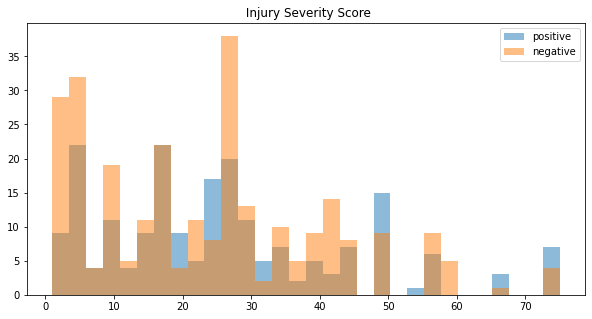

In [717]:
plt.hist(original_matched_data[preds]["iss"], alpha = 0.5, label="positive", bins=30)
plt.hist(original_matched_data[~preds]["iss"],  alpha = 0.5, label="negative", bins=30)
plt.legend()
plt.title(" Injury Severity Score")

In [716]:
original_matched_data[(preds) & (original_matched_data.time_to_injury > 0) & (original_matched_data.time_to_injury < 30)]["time_to_injury"].describe()

# plt.hist(original_matched_data[preds & (original_matched_data.time_to_injury >0)]["time_to_injury"], alpha=0.5, bins=20)

count    98.000000
mean      1.862755
std       3.474431
min       0.133333
25%       0.837500
50%       1.150000
75%       1.562500
max      25.216667
Name: time_to_injury, dtype: float64

In [715]:
original_matched_data[(~preds) & (original_matched_data.time_to_injury > 0) & (original_matched_data.time_to_injury < 30)]["time_to_injury"].describe()

# plt.hist(original_matched_data[~preds & (original_matched_data.time_to_injury >0)]["time_to_injury"])

count    130.000000
mean       1.660385
std        2.003249
min        0.233333
25%        0.854167
50%        1.275000
75%        1.775000
max       19.650000
Name: time_to_injury, dtype: float64

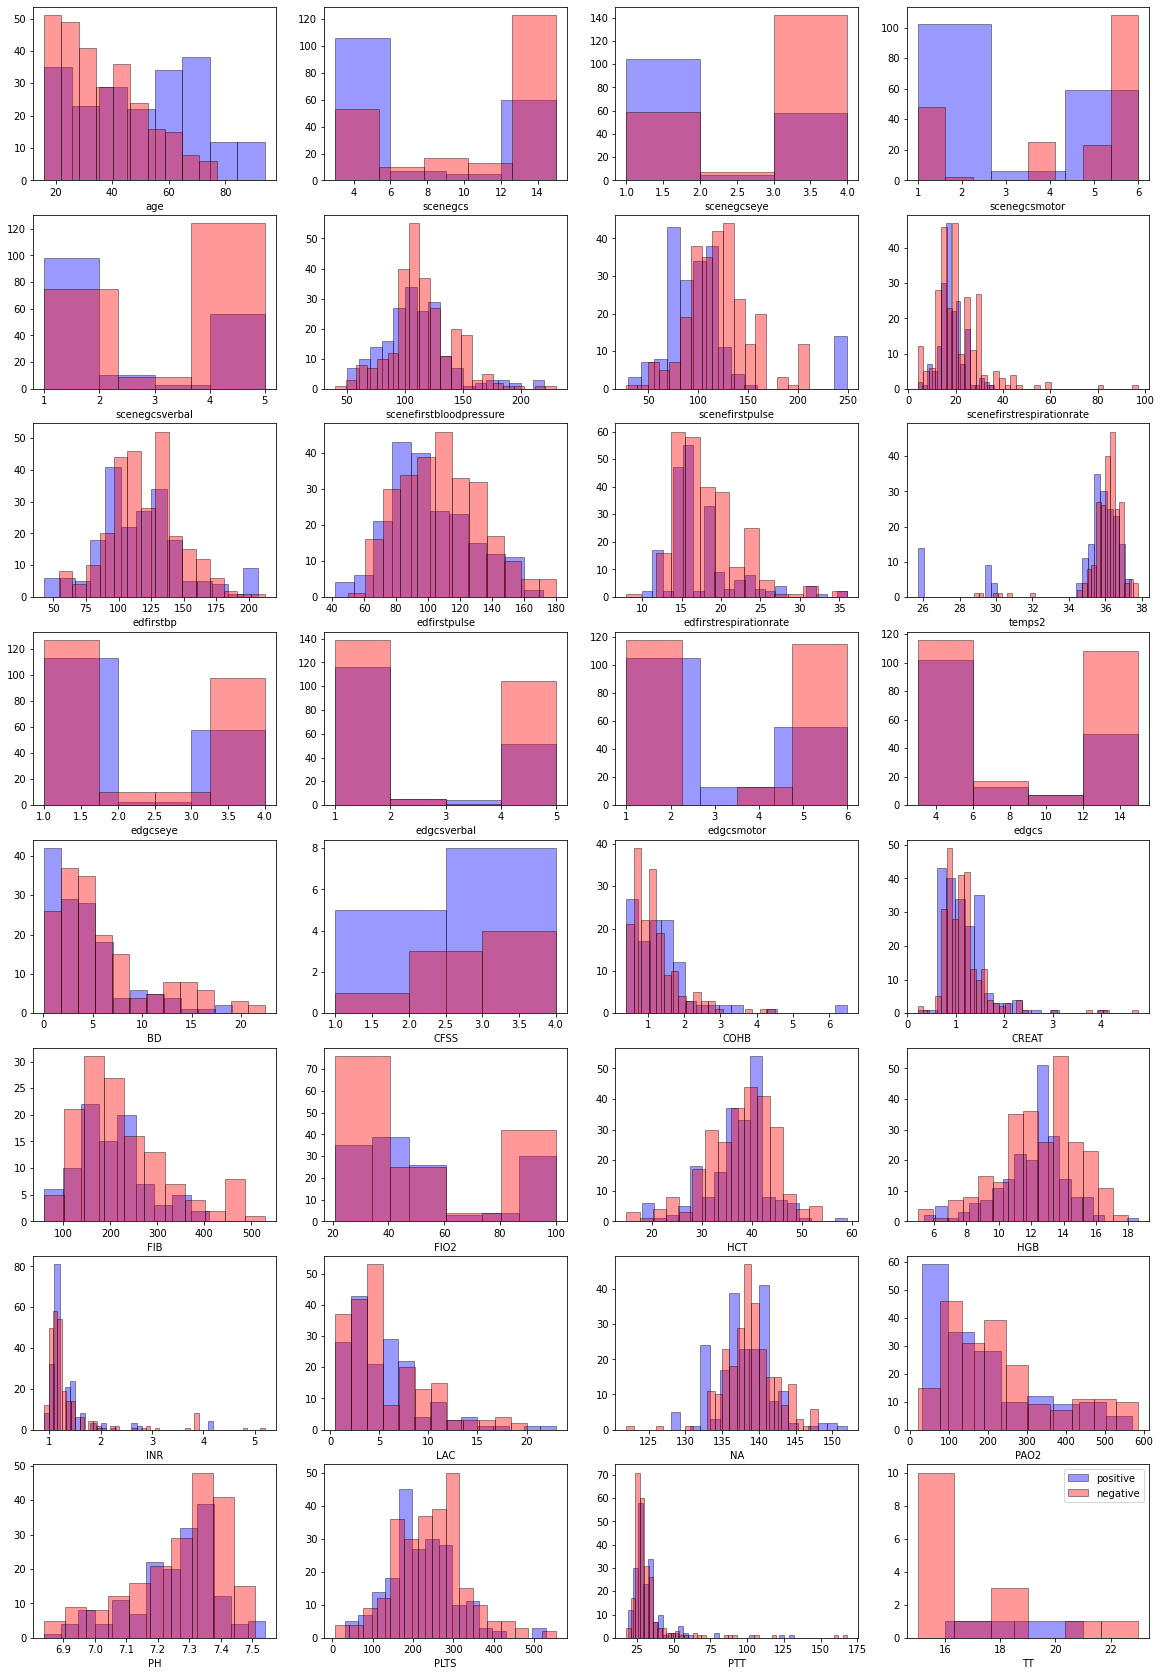

In [658]:
plt.figure(figsize=(20,30))

float_data = ["age","scenegcs","scenegcseye",
              
              "scenegcsmotor","scenegcsverbal",\
             "scenefirstbloodpressure","scenefirstpulse","scenefirstrespirationrate",\
             "edfirstbp", "edfirstpulse", "edfirstrespirationrate","temps2",\
             "edgcseye","edgcsverbal","edgcsmotor","edgcs","BD", "CFSS",\
              "COHB", "CREAT", "FIB", "FIO2", "HCT", "HGB", "INR",\
              "LAC", "NA", "PAO2", "PH", "PLTS", "PTT", "TT"]


for i in range(32):
    ax = plt.subplot(8, 4, i + 1)
    sns.distplot(original_matched_data[preds][float_data[i]], 
                 hist=True, kde=False, color="blue", label="positive",
                 hist_kws={'edgecolor':'black'})
    
    sns.distplot(original_matched_data[~preds][float_data[i]], 
                 hist=True, kde=False, color="red", label="negative",
                 hist_kws={'edgecolor':'black'})
plt.legend()
plt.show()

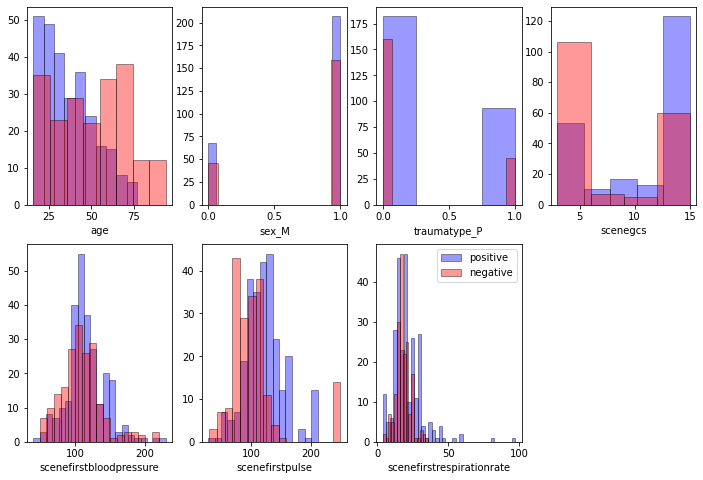

In [703]:
plt.figure(figsize=(12,8))

float_data = ["age","sex_M", "traumatype_P", "scenegcs",
              "scenefirstbloodpressure","scenefirstpulse","scenefirstrespirationrate" ]

for i in range(7):
    ax = plt.subplot(2, 4, i + 1)
    
    sns.distplot(original_matched_data[~preds][float_data[i]], 
                 hist=True, kde=False, color="blue", label="positive",
                 hist_kws={'edgecolor':'black'})
    
    sns.distplot(original_matched_data[preds][float_data[i]], 
                 hist=True, kde=False, color="red", label="negative",
                 hist_kws={'edgecolor':'black'})

plt.legend()
plt.show()